### Semi-autonomous Teleoperation Demo : Place task in `Kitchen Plate` scene with `small size dish rack`

### Parse `Realistic Scene`

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass

from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


In [2]:
xml_path = '../../../asset/scene_kitchen_dish_rack_white.xml'
env = MuJoCoParserClass(name='Place task scene: Plate table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-1.5,80,0])

# Place objects
obj_box_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_box"))]
n_box_obj = len(obj_box_names)
env.place_objects_random(n_obj=n_box_obj, obj_names=obj_box_names, x_range=[0.80, 1.15], y_range=[-3.15, -2.15], COLORS=False, VERBOSE=True)

jntadr_mug_cup = env.model.body('mug_cup').jntadr[0]
env.model.joint(jntadr_mug_cup).qpos0[:3] = np.array([ -0.9, -30, 0.85])
env.model.joint(jntadr_mug_cup).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, np.random.rand() * 360])))

jntadr_tray = env.model.body('tray').jntadr[0]
env.model.joint(jntadr_tray).qpos0[:3] = np.array([-0.9,-30,0.80])
# env.model.joint(jntadr_tray).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, 0])))

jntadr_dish_rack = env.model.body('dish_rack').jntadr[0]
pos_dish_rack = np.array([0.9,0.35,0.82])
env.model.joint(jntadr_dish_rack).qpos0[:3] = pos_dish_rack
dish_rack_random_rot = 0 # np.random.rand() * 360
env.model.joint(jntadr_dish_rack).qpos0[3:] = r2quat(rpy2r(np.radians([0, 0, dish_rack_random_rot])))


# Target dish
env.model.joint(env.model.body('kitchen-plate').jntadr[0]).qpos0[:3] = np.array([0.2, -0.7, 0.8])
# Set the dishes
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = np.array([-0.92, 0.39, 0.95])
env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 360])))
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = np.array([[0.86, 0.39, 0.95]])
env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 360])))
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = np.array([[0.81, 0.39, 0.95]])
env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([0, 90, 360])))
# env.model.joint(env.model.body('kitchen-plate-2').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([0.0,0.02, 0.2])
# env.model.joint(env.model.body('kitchen-plate-3').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-0.05, 0.02, 0.2])
# env.model.joint(env.model.body('kitchen-plate-4').jntadr[0]).qpos0[:3] = pos_dish_rack + np.array([-0.1, 0.02, 0.2])

env.reset()

window


[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


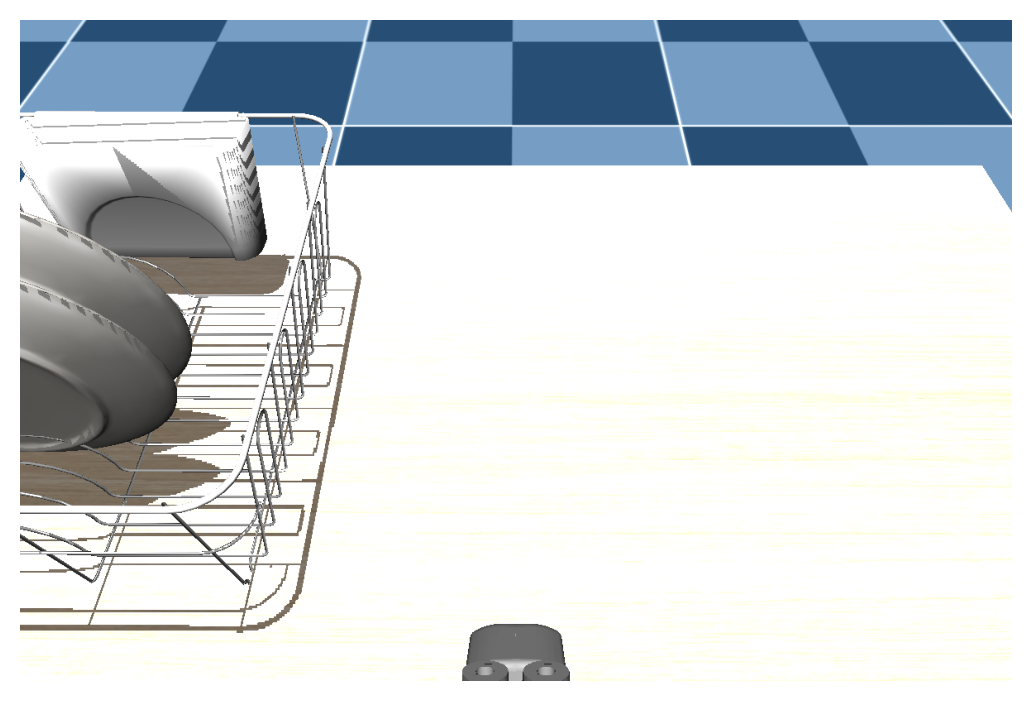

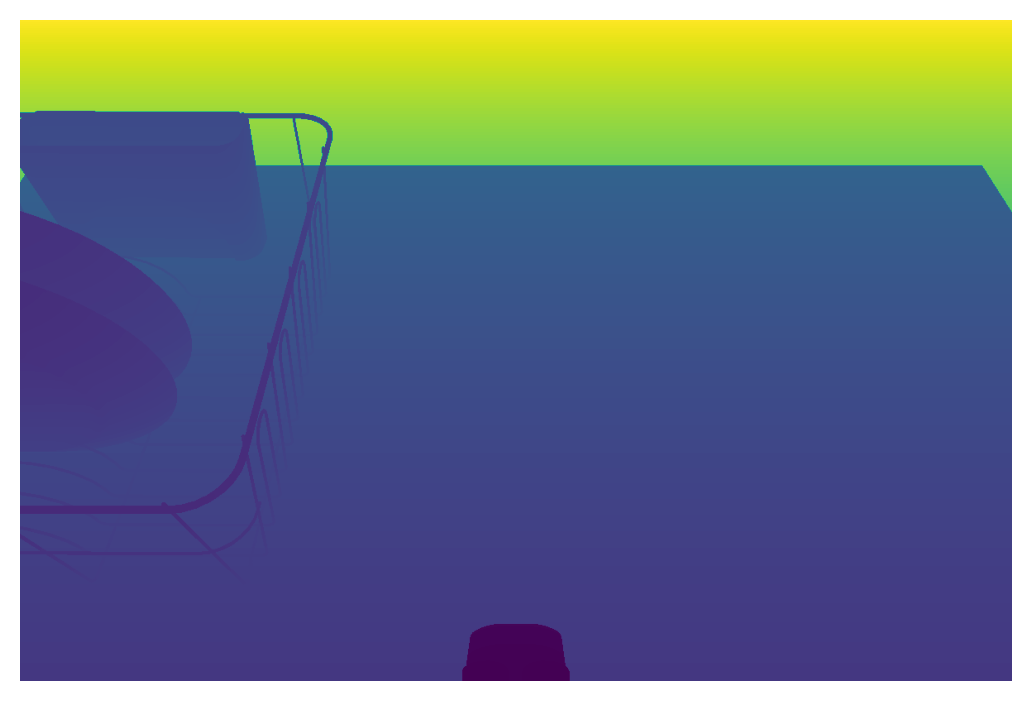

Done. Tick:[352] Time:[0.70]sec


In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] + np.array([0,0,-0.1])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

plt.imshow(rgb_img); plt.axis('off'); plt.show()
plt.imshow(depth_img); plt.axis('off'); plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

#### 1. Place Stability check

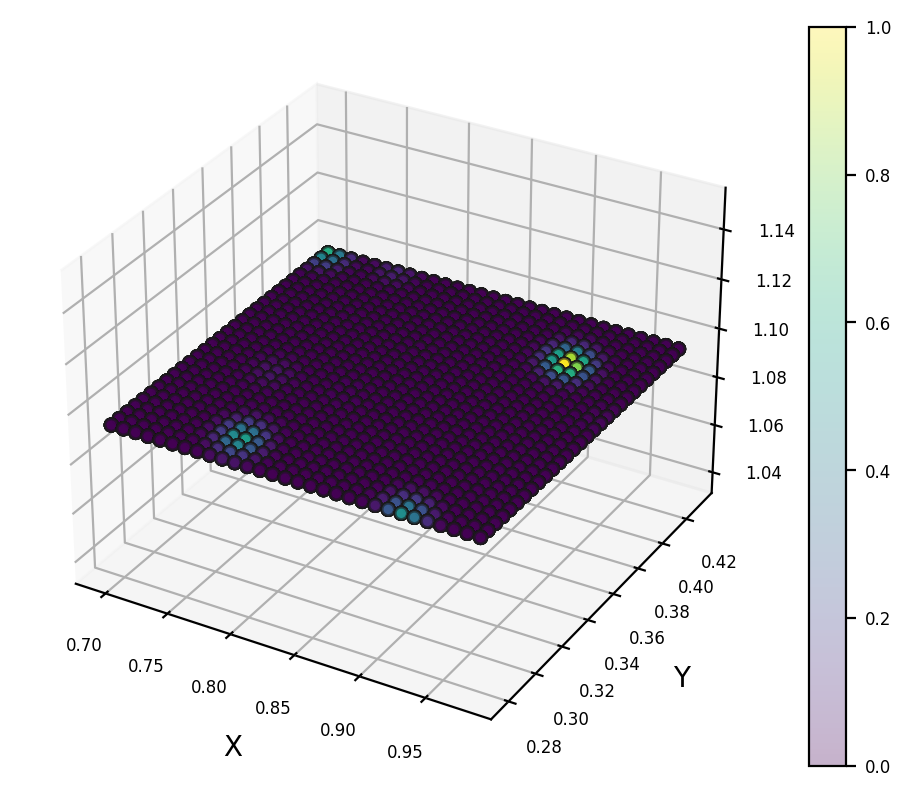

In [9]:
import sys
sys.path.append('../../../utils/')
from score_map import get_score_map, sample_pcd_from_score_map, plot_score_map_w_pcd

# feasible_pcd = np.load('./data/black_feasible.npy')
feasible_pcd = np.load('./data/20230909/white/feasible_pcd_20230908_c48_g4_worker48_2.npy')
quat_range = np.load('./data/20230909/white/quat_range_20230908_c48_g4_worker48_2.npy')
score_p, di_p = get_score_map(feasible_pcd, nbins=30, bandwidth=0.1, PLOT=True, weights=quat_range)


In [10]:
# Function to compute Exponential Weighting
def exponential_weighting(delta_omega, alpha):
    return np.exp(alpha * np.abs(delta_omega))

# Function to compute Linear Weighting
def linear_weighting(delta_omega, gamma):
    return gamma * np.abs(delta_omega)

# Example usage with delta_omega ranging from 0.01 to 0.02 and scaling constants alpha=50, gamma=50
alpha = 100
gamma = 100

exp_weights = exponential_weighting(quat_range, alpha)
lin_weights = linear_weighting(quat_range, gamma)

# print(exp_weights, lin_weights)
# print(exp_weights.shape, lin_weights.shape)
print(lin_weights.shape, exp_weights.shape, feasible_pcd.shape)

(8, 1) (8, 1) (8, 3)


In [11]:
lin_weights, exp_weights

(array([[2.26],
        [0.2 ],
        [0.36],
        [2.11],
        [0.03],
        [1.83],
        [3.81],
        [0.06]]),
 array([[ 9.58],
        [ 1.22],
        [ 1.44],
        [ 8.21],
        [ 1.03],
        [ 6.24],
        [44.99],
        [ 1.07]]))

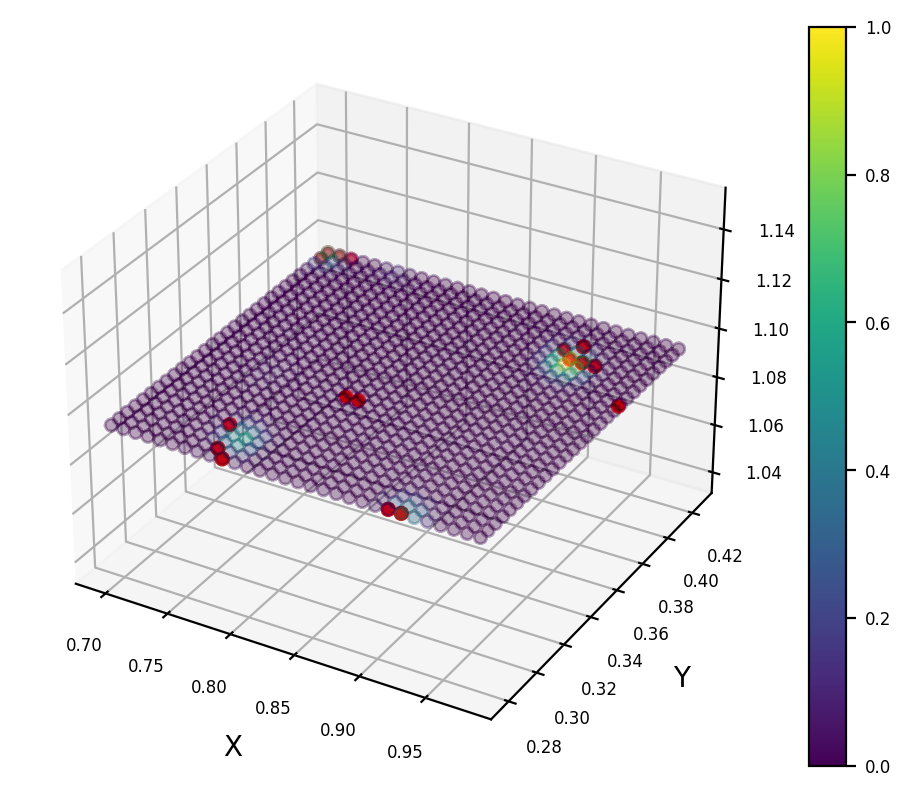

In [13]:
n_samples = 20
sampled_physical = sample_pcd_from_score_map(score_p, feasible_pcd, di_p, nbins=30, num_samples=n_samples)
plot_score_map_w_pcd(score_p, sampled_physical, nbins=30)

#### Execute it !

In [14]:
env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pith", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

Exception: Line name already exists in this plot.

In [15]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'kitchen-plate'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

for p in sampled_physical:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.0])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([0, 90, 360])))
    while env.tick - start < end_tick:
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        # _,f_contacts,_,_,body1s,body2s = env.get_contact_info(must_include_prefix=target_obj_name)
        # print(f"f_contacts: {np.max(np.linalg.norm(np.array(f_contacts)[:,0]))}")
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in sampled_physical]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)

        env.render(render_every=5)
    
    env.reset()
    # print(f"max_f_contact: {np.max(np.array(f_contacts))}")
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    # print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    # print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.2
Position: [0.94 0.4  1.09]
Position: [0.7  0.43 1.09]
Position: [0.82 0.34 1.09]
Position: [0.77 0.28 1.09]
Pressed ESC
Quitting.


Exception: GLFW window does not exist but you tried to render.

### Interact with GPT

In [17]:
import os
import openai
import sys
sys.path.append('../../../')
from utils.gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from utils.wiki_helper import wiki_search
from utils.util import printmd,extract_quoted_words
print ("openai version:[%s]"%(openai.__version__))

openai version:[0.27.8]


In [10]:
# set_openai_api_key_from_txt(key_path='../../../key/rilab_key.txt')
set_openai_api_key_from_txt(key_path='../../../key/my_key.txt')
GPT = GPTchatClass(
    gpt_model='gpt-4', # 'gpt-3.5-turbo' / 'gpt-4'
    role_msg='Your are a helpful assistant summarizing infromation and answering user queries.')

OpenAI API Key Ready from [../../../key/my_key.txt].
Chat agent using [gpt-4] initialized with the follow role:[Your are a helpful assistant summarizing infromation and answering user queries.]


In [11]:
filtered_pointcloud = np.load('./data/black_feasible.npy')

In [12]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0,distance=3.0,elevation=-90,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break        
    # Render
    if env.loop_every(HZ=20):
        for p in filtered_pointcloud: env.plot_sphere(p=p,r=0.005,rgba=[0.05,0.95,0.95,1])
        # for p in intersect_p: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,0.01])
        # [env.plot_sphere(p=sampled_place_, r=0.01, rgba=[1,0,0,1]) for sampled_place_ in uniform_positions]
        env.render(render_every=1)

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[1377] Time:[2.75]sec


In [19]:
env.reset()

# object position lists on the table
obj_pos_list_table = {}
obj_pos_list_table['dish_rack'] = {'position':env.get_p_body('dish_rack'), 'size':np.array([0.17,0.07,0.28])}
obj_pos_list_table['tray'] = {'position':env.get_p_body('tray'), 'size': np.array([0.11,0.15,0.01])}
obj_pos_list_table['mug_cup'] = {'position':env.get_p_body('mug_cup'), 'size': np.array([0.05,0.07,0.1])}
obj_pos_list_table['kitchen-plate-2'] = {'position':env.get_p_body('kitchen-plate-2'), 'size': np.array([0.1,0.1,0.01])}
obj_pos_list_table['kitchen-plate-3'] = {'position':env.get_p_body('kitchen-plate-3'), 'size': np.array([0.1,0.1,0.01])}

print(obj_pos_list_table)
print(list(obj_pos_list_table.keys()))

{'dish_rack': {'position': array([0.9 , 0.35, 0.82]), 'size': array([0.17, 0.07, 0.28])}, 'tray': {'position': array([ -0.9, -30. ,   0.8]), 'size': array([0.11, 0.15, 0.01])}, 'mug_cup': {'position': array([ -0.9 , -30.  ,   0.85]), 'size': array([0.05, 0.07, 0.1 ])}, 'kitchen-plate-2': {'position': array([-0.92,  0.39,  0.95]), 'size': array([0.1 , 0.1 , 0.01])}, 'kitchen-plate-3': {'position': array([0.86, 0.39, 0.95]), 'size': array([0.1 , 0.1 , 0.01])}}
['dish_rack', 'tray', 'mug_cup', 'kitchen-plate-2', 'kitchen-plate-3']


In [20]:
object_description_list = ["plate", "book", "apple", "pockey"]
target_object_name = "plate"

user_msg = \
    f"""
    I will give you some scene descriptions, task descriptions and the user's preferred trajectory information:

    Scene description:
    There are objects of {list(obj_pos_list_table.keys())} on the table. Their respective positions and sizes are shown below.
    - {obj_pos_list_table}
    The table is located at [0.98,0,0.79], and the areas where objects can be placed on the table are shown below.
    - x: [0.65, 1.2]
    - y: [-0.38, 0.38]
    - z: [0.8, 0.9]

    Task description: 
    The task is to place the {target_object_name} on the front table.

    [Rules]
	1. The environment contains {list(obj_pos_list_table.keys())}. Do not invent new objects not listed here.
	2. The terminate condition is either when the manipulator has successfully placed the intended object into the bookshelf, ensuring it is stably settled, or if a critical failure occurs, such as knocking over a wine glass, dropping an object during transfer, or damaging an object or the bookshelf.
	3. You can assume that the robot can do anything, even for the most challenging task.
	4. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
	5. Once you've gotten as much information as you think you need to perform the task, you can do it without asking any more questions, and you NEED to say, 'I get it.'. You should describe your plan in detail.
    6. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], Spatial_Relationship_to_the_Object, use ONLY the list of objects I provided.
    7. The clusters of the regions are just for reference. But the categories of the regions are not fixed. You can change the categories of the regions if you think it is necessary.
	
    This is an example of instruction. For example, answer the output following instructions.
    For example, the answer can be like this:

    User: Based on the information I have provided, please recommend a suitable area to place {target_object_name} to accomplish the task successfully, and also let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
        On the table, there are dish-rack, tray, mug cup. Already two dishes are placed in the dish-rack. The fragile mug cup is on the tray. I want to place the dish. Say where is the best fit placement region?

    GPT-4: Certainly! I have analyzed the provided positions and clustered them into five groups based on their spatial relationships and proximity to other objects in the table. 
    Here are the clusters:
    I recommend the region [Dish_Rack] to place the {target_object_name}. This area provides a balance between accessibility and stability, without interfering with other objects on the table. It's also aesthetically pleasing as it maintains symmetry on the table.
    And I recommend not to place the {target_object_name} in the region [Mug_Cup]. This area is too close to the mug cup, which may cause the {target_object_name} to fall down when the robot is trying to place it.
    Summary: Recommended region: [Dish_Rack], Not recommended region: [Mug_Cup]

    If you understand, Say "I understand" and I will start the simulation.
    """

In [21]:
response_content = GPT.chat(
    user_msg=user_msg,PRINT_USER_MSG=True,PRINT_GPT_OUTPUT=True,
    RESET_CHAT=True,RETURN_RESPONSE=True)

[USER_MSG]



    I will give you some scene descriptions, task descriptions and the user's preferred trajectory information:

    Scene description:
    There are objects of ['dish_rack', 'tray', 'mug_cup', 'kitchen-plate-2', 'kitchen-plate-3'] on the table. Their respective positions and sizes are shown below.
    - {'dish_rack': {'position': array([0.9 , 0.35, 0.82]), 'size': array([0.17, 0.07, 0.28])}, 'tray': {'position': array([ -0.9, -30. ,   0.8]), 'size': array([0.11, 0.15, 0.01])}, 'mug_cup': {'position': array([ -0.9 , -30.  ,   0.85]), 'size': array([0.05, 0.07, 0.1 ])}, 'kitchen-plate-2': {'position': array([-0.92,  0.39,  0.95]), 'size': array([0.1 , 0.1 , 0.01])}, 'kitchen-plate-3': {'position': array([0.86, 0.39, 0.95]), 'size': array([0.1 , 0.1 , 0.01])}}
    The table is located at [0.98,0,0.79], and the areas where objects can be placed on the table are shown below.
    - x: [0.65, 1.2]
    - y: [-0.38, 0.38]
    - z: [0.8, 0.9]

    Task description: 
    The task is to place the plate on the front table.

    [Rules]
	1. The environment contains ['dish_rack', 'tray', 'mug_cup', 'kitchen-plate-2', 'kitchen-plate-3']. Do not invent new objects not listed here.
	2. The terminate condition is either when the manipulator has successfully placed the intended object into the bookshelf, ensuring it is stably settled, or if a critical failure occurs, such as knocking over a wine glass, dropping an object during transfer, or damaging an object or the bookshelf.
	3. You can assume that the robot can do anything, even for the most challenging task.
	4. Your plan should be as close to the provided template as possible. You can add additional information if you think it is necessary.
	5. Once you've gotten as much information as you think you need to perform the task, you can do it without asking any more questions, and you NEED to say, 'I get it.'. You should describe your plan in detail.
    6. You can say the region(area) where the object can be placed on the table. You should follow this format: [Object_Name], Spatial_Relationship_to_the_Object, use ONLY the list of objects I provided.
    7. The clusters of the regions are just for reference. But the categories of the regions are not fixed. You can change the categories of the regions if you think it is necessary.
	
    This is an example of instruction. For example, answer the output following instructions.
    For example, the answer can be like this:

    User: Based on the information I have provided, please recommend a suitable area to place plate to accomplish the task successfully, and also let me know which region(area) is unsuitable to place it for the same purpose. Only you can say the region.
        On the table, there are dish-rack, tray, mug cup. Already two dishes are placed in the dish-rack. The fragile mug cup is on the tray. I want to place the dish. Say where is the best fit placement region?

    GPT-4: Certainly! I have analyzed the provided positions and clustered them into five groups based on their spatial relationships and proximity to other objects in the table. 
    Here are the clusters:
    I recommend the region [Dish_Rack] to place the plate. This area provides a balance between accessibility and stability, without interfering with other objects on the table. It's also aesthetically pleasing as it maintains symmetry on the table.
    And I recommend not to place the plate in the region [Mug_Cup]. This area is too close to the mug cup, which may cause the plate to fall down when the robot is trying to place it.
    Summary: Recommended region: [Dish_Rack], Not recommended region: [Mug_Cup]

    If you understand, Say "I understand" and I will start the simulation.
    

[GPT_OUTPUT]


Certainly, based on the provided scene and task description, I have analyzed the table and object positions. 

According to the spatial information, the dish rack is located at [0.9 , 0.35, 0.82] while other elements, such as tray and mug cup, are far from the table at [-0.9, -30. , 0.8] and [-0.9 , -30. , 0.85] respectively.

To successfully complete the task, I will recommend placing the kitchen plate in the region near [Dish_Rack]. This position is within the table's dimensions that can accommodate objects i.e. x: [0.65, 1.2], y: [-0.38, 0.38], and z: [0.8, 0.9]. This will ensure that the plate is placed on the table properly and securely without disturbing any other objects.

On the other hand, the area near [Tray] and [Mug_Cup] is recommended to be avoided as they are currenty far away from the table, possibly indicating an unsuitable or unstable surface for placing the kitchen plate. 

Summary: 
Recommended region: [Near Dish_Rack], 
Not recommended region: [Near Tray and Mug_Cup]

If you understand this plan, please say "I understand", and I will proceed with the task.

In [ ]:
import re

text = response_content
pattern_recommended = r'recommended region: \[(.*?)\]'
pattern_not_recommended = r'not recommended region: \[(.*?)\]'

# Use re.search to find the first occurrence of the patterns
recommended_region = re.search(pattern_recommended, text.lower())
not_recommended_region = re.search(pattern_not_recommended, text.lower())

# Extract the matched groups
recommended_region = recommended_region.group(1) if recommended_region else None
not_recommended_region = not_recommended_region.group(1) if not_recommended_region else None

recommended_region, not_recommended_region

('kitchen-drainer', 'mug_cup')

### Get `the region` from the response sentence.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def get_zero_map(resolution=(5,5,5)):
    """
        Get the zero map: (N x 3) array
    """
    zero_map = np.zeros((resolution[0]*resolution[1]*resolution[2], 3))

    return zero_map

def get_score_map(pcd, nbins=30, bandwidth=0.1, PLOT=False):
    """
        Get the score of the physical safety score
    """
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]

    # Create KDE
    density = stats.gaussian_kde(pcd.T, bw_method=bandwidth)
    nbins = nbins
    xi, yi, zi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j, z.min():z.max():nbins*1j]

    # Compute density
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    di = density(coords).reshape(xi.shape)

    # Normalize density (around 1)
    di_normalized = di / np.max(di)
    # score_physical = di_normalized

    if PLOT:
        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi.flatten(), yi.flatten(), zi.flatten(), c=di_normalized.flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)

        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.colorbar(scatter, ax=ax)
        plt.show()

    return di_normalized, di

def get_score_map_penalty(pcd, nbins=30, bandwidth=0.1, penalty=0.5, PLOT=False):
    """
        Get the score of the physical safety score
    """
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]

    # Create KDE
    density = stats.gaussian_kde(pcd.T, bw_method=bandwidth)
    nbins = nbins
    xi, yi, zi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j, z.min():z.max():nbins*1j]

    # Compute density
    coords = np.vstack([item.ravel() for item in [xi, yi, zi]])
    di = density(coords).reshape(xi.shape)

    # Normalize density (around 1)
    di_normalized = di / np.max(di)
    score_physical = di_normalized

    # Get the penalty score
    # score_penalty = np.exp(-penalty * di_normalized)
    score_penalty = 1 - penalty * di_normalized
    
    # Get the final score
    score_final = score_physical - score_penalty
    # score_final[score_final < 0] = 0

    if PLOT:
        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(xi.flatten(), yi.flatten(), zi.flatten(), c=score_final.flatten(), cmap='viridis', edgecolor='0.1', alpha=0.3)

        plt.xlabel('X')
        plt.ylabel('Y')
        ax.set_zlabel('Z')
        plt.colorbar(scatter, ax=ax)
        plt.show()

    return score_final, di

def sample_pcd_from_score_map(score_map, pcd, di, nbins, num_samples=10):
    """
        Sample the pcd from the score_map
    """
    # Flatten the normalized score_physical
    score_map_flat = score_map.flatten()
    score_map_norm = score_map_flat / np.sum(score_map_flat)

    sampled_indices = np.random.choice(len(score_map_flat), size=num_samples, p=score_map_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, di.shape)).T

    # Convert indices to actual coordinates
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
    x_range = np.linspace(x.min(), x.max(), nbins)
    y_range = np.linspace(y.min(), y.max(), nbins)
    z_range = np.linspace(z.min(), z.max(), nbins)

    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T

    return sampled_xyz

def plot_score_map(score_map, pcd, nbins):
    """
        Plot the score map
    """
    x, y, z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
    xi, yi, zi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j, z.min():z.max():nbins*1j]

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    origin_pcd = ax.scatter(x, y, z, c='r', marker='o', s=10)

    plt.xlabel('X')
    plt.ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(x, y, z, c='r', marker='o')
    ax.scatter(xi.flatten(), yi.flatten(), zi.flatten(), c=score_map.flatten(), cmap='viridis', alpha=0.01)
    plt.colorbar(origin_pcd, ax=ax)
    plt.show()

In [ ]:
from utils.util import fill_object, get_geom_region_type1, get_geom_region_type2, get_geom_region_type3, get_geom_region_type4

def get_region_pcd(recommended_obj, not_recommended_obj, resolution_obj=(5,5,5)):
    stacked_rec_region = stacked_not_rec_region = None
    
    if recommended_obj.lower() == "drainer" or recommended_obj.lower() == "kitchen-drainer":
        recommended_region = fill_object(get_geom_region_type4(env, 'kitchen-drainer'), resolution_obj)

        stacked_rec_region = np.vstack([
            recommended_region
        ])
    elif recommended_obj.lower() == "mug_cup":
        recommended_region = fill_object(get_geom_region_type3(env, 'mug_cup'), resolution_obj)

        stacked_rec_region = np.vstack([
            recommended_region
        ])

    elif recommended_obj.lower() == "tray":
        recommended_region = fill_object(get_geom_region_type4(env, 'tray'), resolution_obj)

        stacked_rec_region = np.vstack([
            recommended_region
        ])

    if not_recommended_obj.lower() == "drainer" or not_recommended_obj.lower() == "kitchen-drainer":
        not_recommended_region = fill_object(get_geom_region_type4(env, 'kitchen-drainer'), resolution_obj)

        stacked_not_rec_region = np.vstack([
            not_recommended_region
        ])

    elif not_recommended_obj.lower() == "mug_cup":
        not_recommended_region = fill_object(get_geom_region_type3(env, 'mug_cup'), resolution_obj)

        stacked_not_rec_region = np.vstack([
            not_recommended_region
        ])

    elif not_recommended_obj.lower() == "tray":
        not_recommended_region = fill_object(get_geom_region_type4(env, 'tray'), resolution_obj)

        stacked_not_rec_region = np.vstack([
            not_recommended_region
        ])

    return stacked_rec_region, stacked_not_rec_region

In [ ]:
rec_pcd, not_rec_pcd = get_region_pcd(recommended_region, not_recommended_region)
print(recommended_region, not_recommended_region)

kitchen-drainer mug_cup


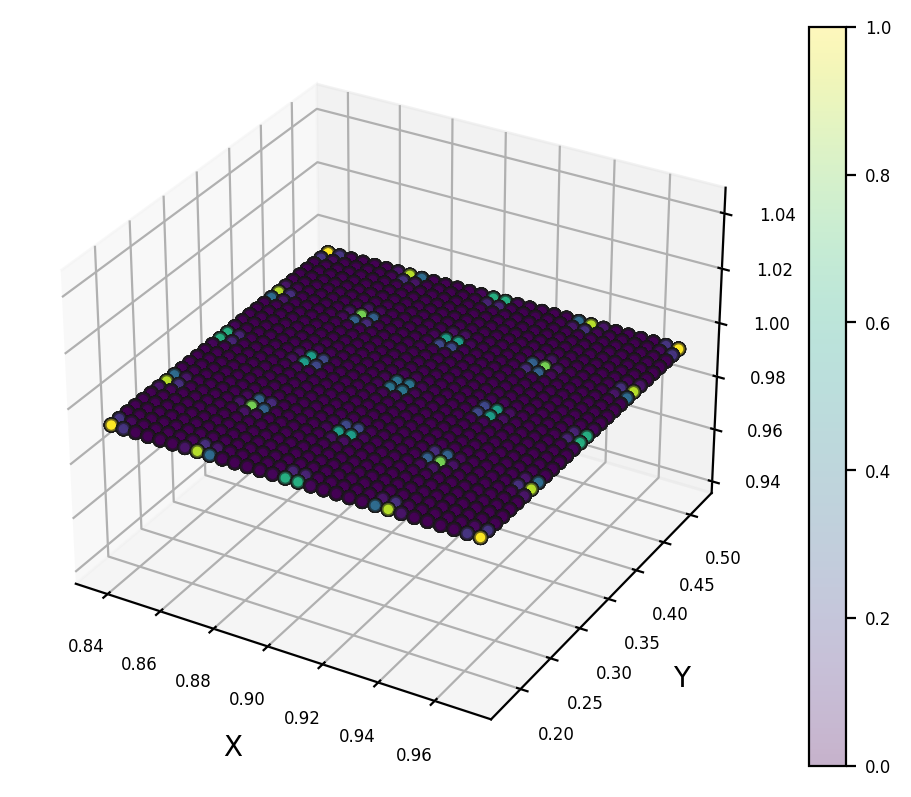

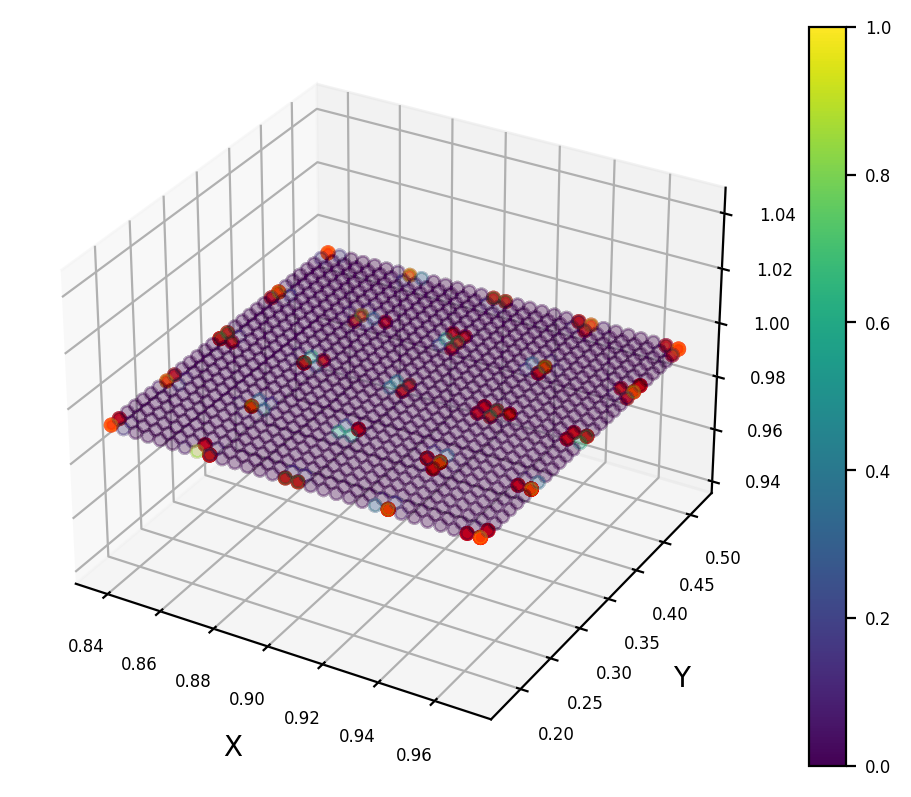

In [ ]:
bandwidth = 0.05
nbins = 30
n_samples = 100

if rec_pcd is not None:
    score_map, di = get_score_map(rec_pcd, nbins=nbins, bandwidth=bandwidth, PLOT=True)
    sampled_physical = sample_pcd_from_score_map(score_map, rec_pcd, di, nbins=nbins, num_samples=n_samples)
    plot_score_map(score_map, sampled_physical, nbins=nbins)
else:
    print("No recommended region")

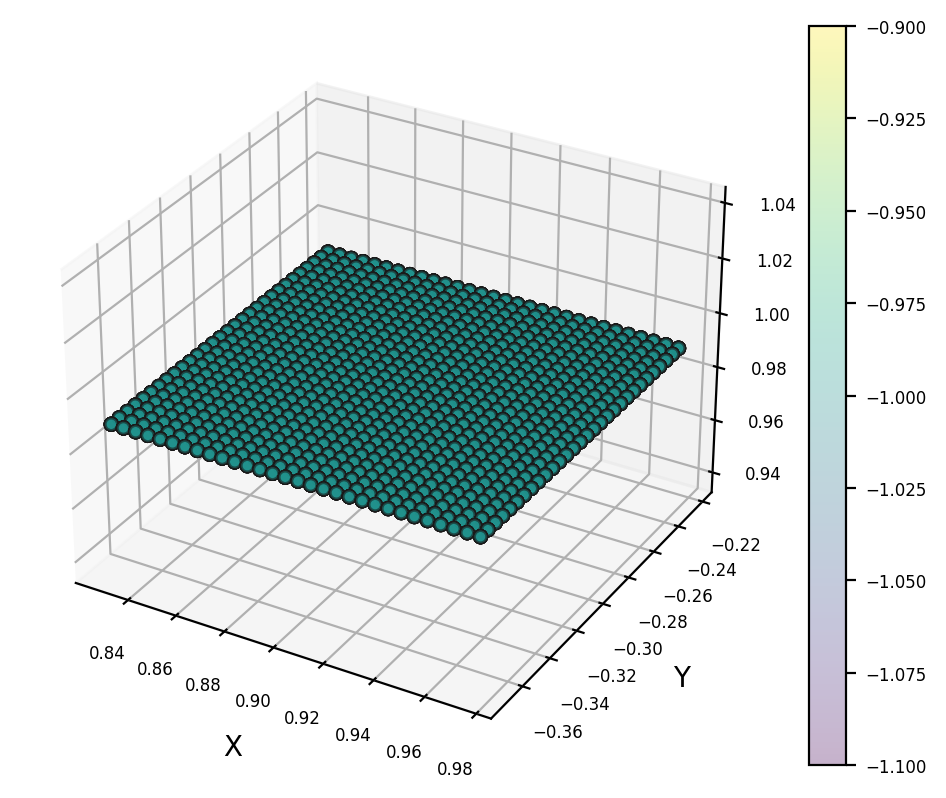

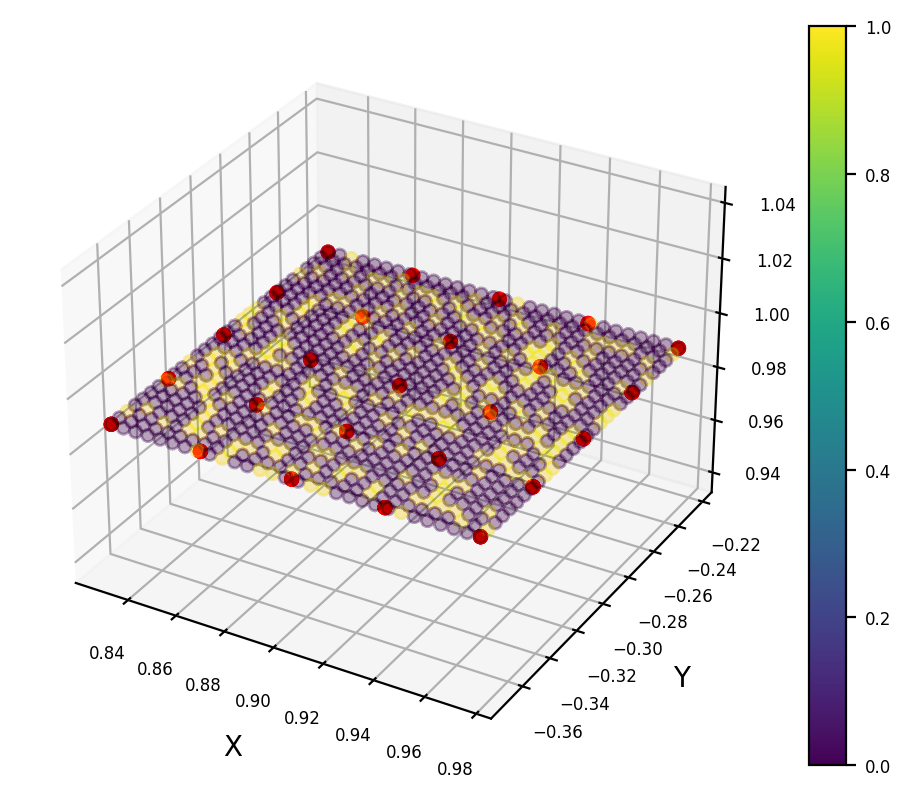

In [ ]:
bandwidth = 0.1
nbins = 30
n_samples = 100

if not_rec_pcd is not None:
    # score_map, di = get_score_map(not_rec_pcd, nbins=nbins, bandwidth=bandwidth, PLOT=True)
    score_map, di = get_score_map_penalty(not_rec_pcd, nbins=nbins, bandwidth=bandwidth, penalty=-1,PLOT=True)
    plot_score_map(score_map, not_rec_pcd, nbins=nbins)
else:
    print("There's nothing to avoid")

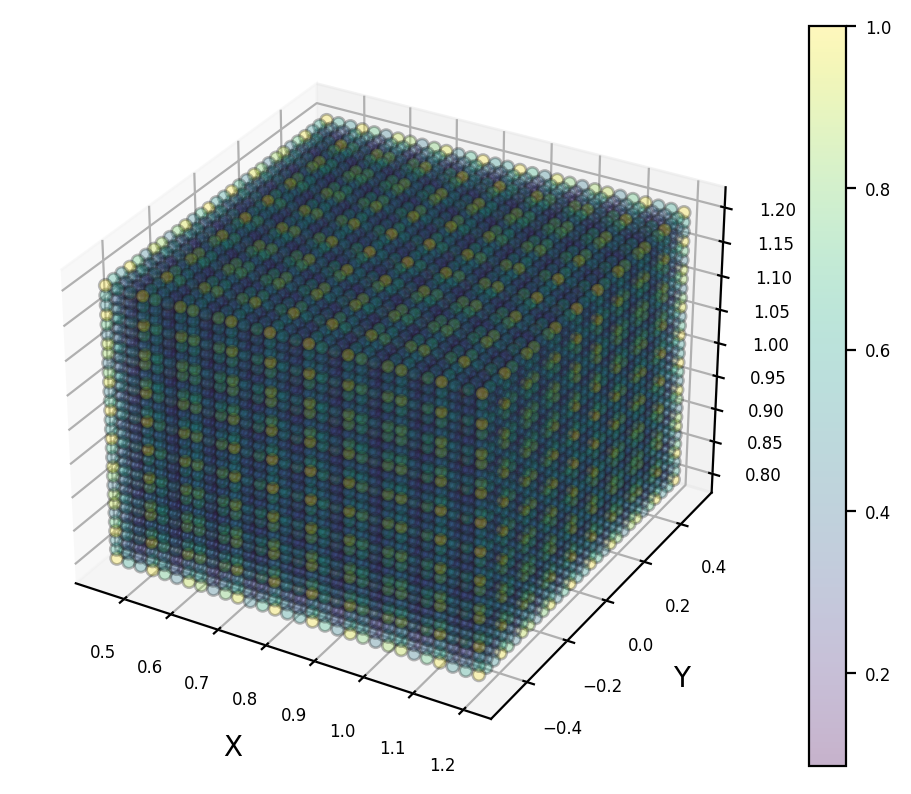

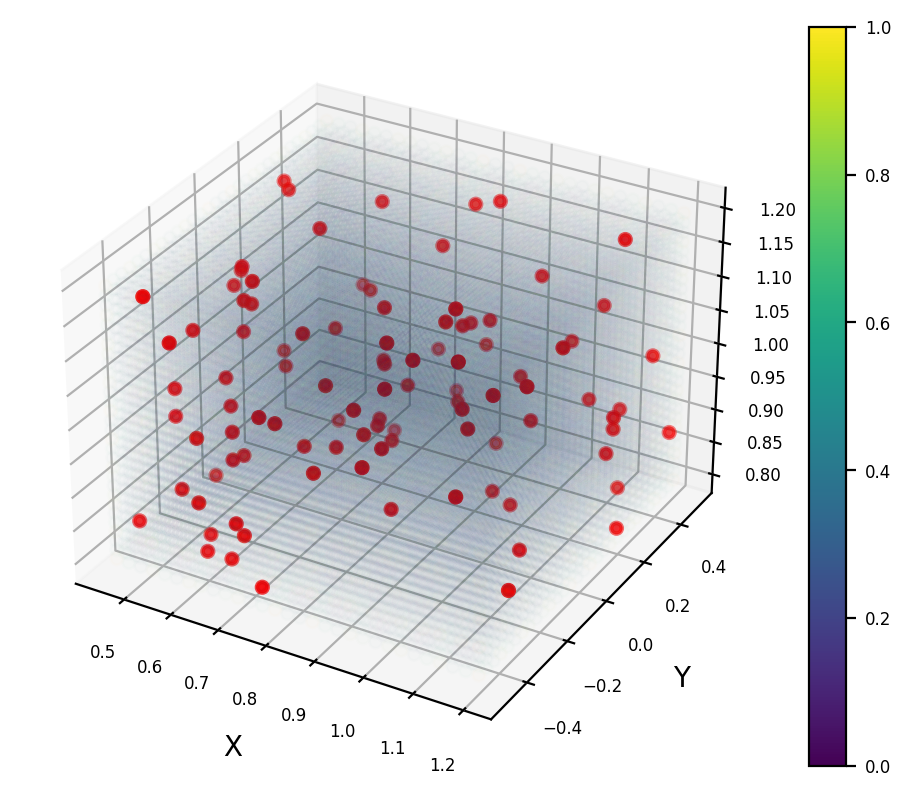

(1000, 3)


In [ ]:
def get_workspace_pcd(x_range=[0.45, 1.2], y_range=[-0.5,0.5], z_range=[0.8,1.2], resolution=(5,5,5)):
    x = np.linspace(x_range[0], x_range[1], resolution[0])
    y = np.linspace(y_range[0], y_range[1], resolution[1])
    z = np.linspace(z_range[0], z_range[1], resolution[2])

    xx, yy, zz = np.meshgrid(x, y, z)
    workspace_pcd = np.vstack([xx.flatten(), yy.flatten(), zz.flatten()]).T

    return workspace_pcd

workspace_pcd = get_workspace_pcd(x_range=[0.45, 1.2], y_range=[-0.5,0.5], z_range=[0.8,1.2], resolution=(10,10,10))
# workspace_pcd = get_zero_map(resolution=(10,10,10))

workspace_score_map, di = get_score_map(workspace_pcd, nbins=nbins, bandwidth=bandwidth, PLOT=True)
workspace_sampled_physical = sample_pcd_from_score_map(workspace_score_map, workspace_pcd, di, nbins=nbins, num_samples=n_samples)
plot_score_map(workspace_score_map, workspace_sampled_physical, nbins=nbins)

print(workspace_pcd.shape)

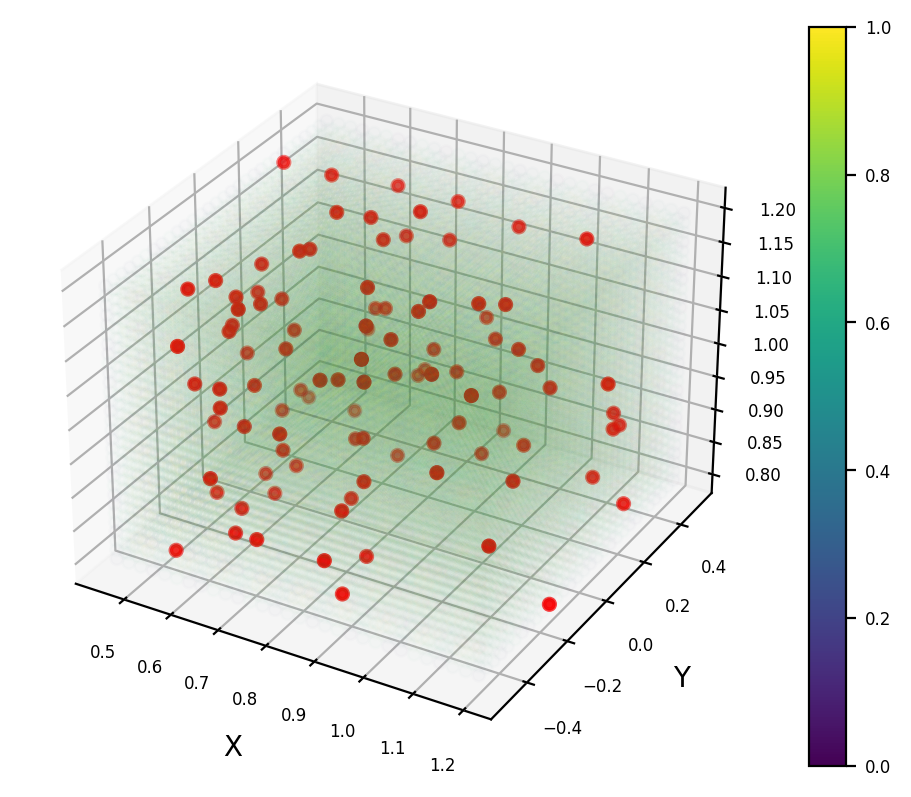

In [ ]:
# 두 KDE 합치기 (정규화 전)
KDE_combined_unnormalized = workspace_score_map + score_map

# 결과를 정규화
KDE_combined_normalized = KDE_combined_unnormalized / np.sum(KDE_combined_unnormalized)

plot_score_map(KDE_combined_normalized, sampled_physical, nbins=nbins)


In [ ]:
workspace_pcd = get_workspace_pcd(x_range=[0.45, 1.2], y_range=[-0.5,0.5], z_range=[0.8,1.2], resolution=(10,10,10))
print(workspace_pcd.shape)
workspace_pcd = get_zero_map(resolution=(10,10,10))
print(workspace_pcd.shape)

(1000, 3)
(1000, 3)


In [ ]:
def merge_subspaces_into_workspace(workspace_pcd, subspaces_pcds, merge_strategy='replace'):
    """
    Merge sub-spaces into the workspace point cloud.
    """
    # Initialize the merged workspace with the original workspace point cloud
    merged_workspace = np.copy(workspace_pcd)

    for sub_pcd in subspaces_pcds:
        # Find the intersecting indices between the workspace and the sub-space
        intersecting_indices = np.isin(workspace_pcd[:, :3], sub_pcd).all(axis=1)
        sub_intersecting_indices = np.isin(sub_pcd, workspace_pcd).all(axis=1)

        if merge_strategy == 'replace':
            merged_workspace[intersecting_indices] = sub_pcd[sub_intersecting_indices]
        elif merge_strategy == 'max':
            merged_workspace[intersecting_indices] = np.maximum(merged_workspace[intersecting_indices], sub_pcd[sub_intersecting_indices])
        elif merge_strategy == 'min':
            merged_workspace[intersecting_indices] = np.minimum(merged_workspace[intersecting_indices], sub_pcd[sub_intersecting_indices])
        elif merge_strategy == 'average':
            merged_workspace[intersecting_indices] = (merged_workspace[intersecting_indices] + sub_pcd[sub_intersecting_indices]) / 2
        else:
            raise ValueError("Invalid merge strategy")

    return merged_workspace

# Sample test
workspace_pcd = np.zeros((10, 3))
subspaces_pcds = [np.array([[0, 0, 1], [0, 1, 1], [1, 1, 1]]), np.array([[0, 0, 2], [0, 1, 2], [1, 1, 2]])]

merged_workspace = merge_subspaces_into_workspace(workspace_pcd, subspaces_pcds)
merged_workspace


ValueError: shape mismatch: value array of shape (0,3) could not be broadcast to indexing result of shape (10,3)